# Preprocessing and cleaning of the data part 3


In [389]:
import pandas as pd
import missingno as msno

In [390]:
data = pd.read_csv("data/data.csv")

In [391]:
def column_label_to_index(col_label):
    col_index = 0
    for c in col_label.upper():
        col_index = col_index * 26 + (ord(c) - ord('A') + 1)
    return col_index - 1


def add_prefix_to_first_row(dataframe, prefix, start_col_label, end_col_label):
    start_col = column_label_to_index(start_col_label)
    end_col = column_label_to_index(end_col_label)
    for col in range(start_col, end_col + 1):
        dataframe.iat[0, col] = prefix + dataframe.iat[0, col]

In [392]:
add_prefix_to_first_row(data, 'PESSOA_PIPEDRIVE_', 'A', 'R')
add_prefix_to_first_row(data, 'FUNIL_ASSINATURA_PIPEDRIVE_', 'S', 'X')
add_prefix_to_first_row(data, 'FUNIL_ONBOARDING_PIPEDRIVE_', 'Y', 'AH')
add_prefix_to_first_row(data, 'ATENDIMENTOS_AGENDA_', 'AI', 'AU')
add_prefix_to_first_row(data, 'WHOQOL_', 'AV', 'AZ')
add_prefix_to_first_row(data, 'COMUNICARE_', 'BA', 'BA')
add_prefix_to_first_row(data, 'TWILIO_', 'BB', 'BI')
add_prefix_to_first_row(data, 'COBRANÇA_VINDI_', 'BJ', 'BQ')

In [393]:
data.columns = data.iloc[0]
data = data.drop(data.index[0])

In [394]:
data = data.drop(["PESSOA_PIPEDRIVE_id_person_recommendation","PESSOA_PIPEDRIVE_Recebe Comunicados?", "PESSOA_PIPEDRIVE_Interesses", "PESSOA_PIPEDRIVE_Pontos de Atenção", "FUNIL_ONBOARDING_PIPEDRIVE_id_label"], axis=1)

<AxesSubplot:xlabel='0'>

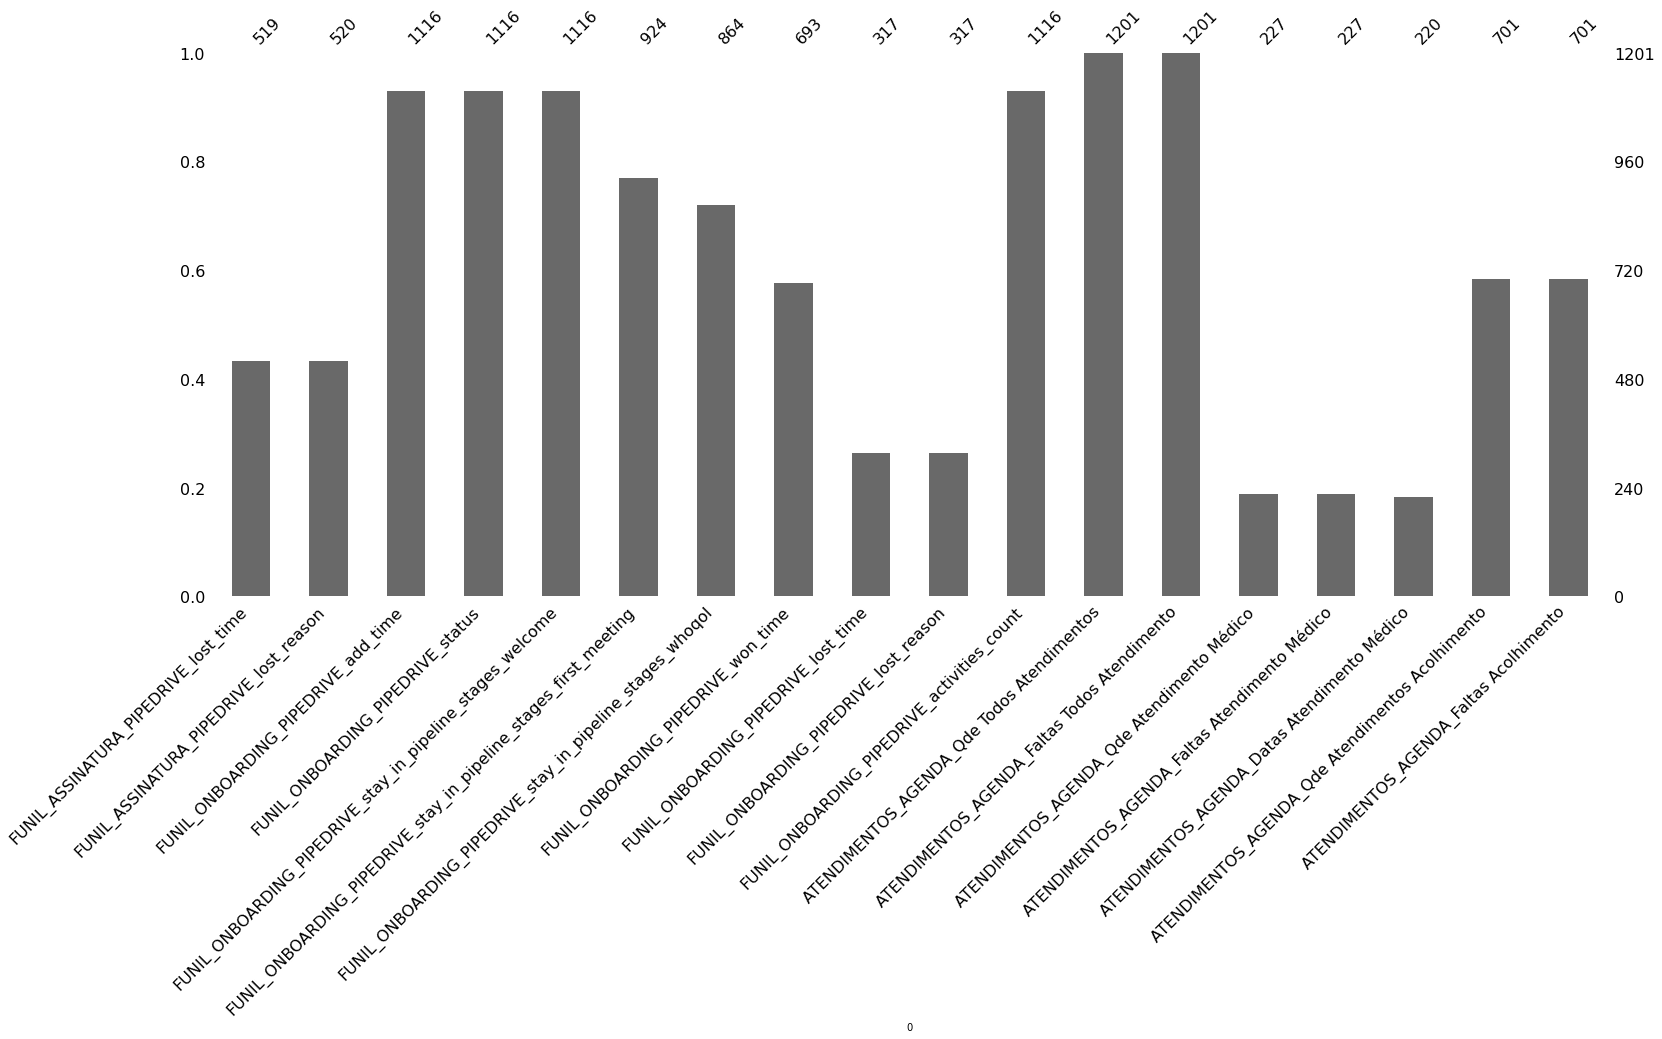

In [395]:
msno.bar(data.iloc[:,18:36])

## FUNIL_ASSINATURA_PIPEDRIVE_lost_time 

In [396]:
data["FUNIL_ASSINATURA_PIPEDRIVE_lost_time"]

1       NaN
2       NaN
3       NaN
4       NaN
5       NaN
       ... 
1197    NaN
1198    NaN
1199    NaN
1200    NaN
1201    NaN
Name: FUNIL_ASSINATURA_PIPEDRIVE_lost_time, Length: 1201, dtype: object

Se existe algum contrato finalizado com lost time = null, insere a data de fim do contrato. Para o restante, substitui "null" por "em aberto", pois significa que o contrato ainda está em andamento. Quando há mais de uma data, pega a primeira data e normaliza todos para o modelo YYYY-MM-DD


In [397]:
import pandas as pd
from datetime import *

for indice, valor in data["FUNIL_ASSINATURA_PIPEDRIVE_lost_time"].items():
  if pd.notna(valor) == False: 
    if pd.notna(data.loc[indice, "PESSOA_PIPEDRIVE_contract_end_date"]):
      data.loc[indice, "FUNIL_ASSINATURA_PIPEDRIVE_lost_time"] =  data.loc[indice, "PESSOA_PIPEDRIVE_contract_end_date"]
    else:
      data.loc[indice, "FUNIL_ASSINATURA_PIPEDRIVE_lost_time"] = "Em aberto"

for indice, valor in data["FUNIL_ASSINATURA_PIPEDRIVE_lost_time"].items():
  if data.loc[indice, "FUNIL_ASSINATURA_PIPEDRIVE_lost_time"] != "Em aberto":
      index = data.loc[indice, "FUNIL_ASSINATURA_PIPEDRIVE_lost_time"].find(";")
      if index != -1:
        data.loc[indice, "FUNIL_ASSINATURA_PIPEDRIVE_lost_time"] = data.loc[indice, "FUNIL_ASSINATURA_PIPEDRIVE_lost_time"][:index]

for indice, valor in data["FUNIL_ASSINATURA_PIPEDRIVE_lost_time"].items():
  if data.loc[indice, "FUNIL_ASSINATURA_PIPEDRIVE_lost_time"] != "Em aberto":
    tamanho = len(data.loc[indice, "FUNIL_ASSINATURA_PIPEDRIVE_lost_time"])
    if tamanho > 10:
      data.loc[indice, "FUNIL_ASSINATURA_PIPEDRIVE_lost_time"] = data.loc[indice, "FUNIL_ASSINATURA_PIPEDRIVE_lost_time"][:10]	

## Coluna extra: Tempo de permanência

Coluna criada para calcular tempo total do usuário na plataforma. Utiliza lost_time - start_of_service ou lost_time - contract_start_date, se os dados de start_of_service forem nulos.

In [398]:
import pandas as pd
from datetime import datetime

tempo_permanencia = []

for indice, valor in data["FUNIL_ASSINATURA_PIPEDRIVE_start_of_service"].items():
  if pd.notna(valor):
      index = data.loc[indice, "FUNIL_ASSINATURA_PIPEDRIVE_start_of_service"].find(";")
      if index != -1:
        data.loc[indice, "FUNIL_ASSINATURA_PIPEDRIVE_start_of_service"] = data.loc[indice, "FUNIL_ASSINATURA_PIPEDRIVE_start_of_service"][:index]

for indice, valor in data["FUNIL_ASSINATURA_PIPEDRIVE_lost_time"].items():
  if pd.notna(valor):
    if data.loc[indice, "FUNIL_ASSINATURA_PIPEDRIVE_lost_time"] != "Em aberto":	
      if pd.notna(data.loc[indice, "FUNIL_ASSINATURA_PIPEDRIVE_start_of_service"]):
        tempo_1 = datetime.strptime(data.loc[indice, "FUNIL_ASSINATURA_PIPEDRIVE_lost_time"], '%Y-%m-%d')
        tempo_2 = datetime.strptime(data.loc[indice, "FUNIL_ASSINATURA_PIPEDRIVE_start_of_service"], '%Y-%m-%d')
        tempo_permanencia.append(str(tempo_1 - tempo_2))
      else:
        tempo_1 = datetime.strptime(data.loc[indice, "FUNIL_ASSINATURA_PIPEDRIVE_lost_time"], '%Y-%m-%d')
        tempo_2 = datetime.strptime(data.loc[indice, "PESSOA_PIPEDRIVE_contract_start_date"], '%Y-%m-%d')
        tempo_permanencia.append(str(tempo_1 - tempo_2))
    else:
      tempo_permanencia.append("Em aberto")

data['stay_time'] = tempo_permanencia

for indice, valor in data["stay_time"].items():
  if valor != "Em aberto":
    index = data.loc[indice, "stay_time"].find(",")
    if index != -1:
      data.loc[indice, "stay_time"] = data.loc[indice, "stay_time"][:index]
    
data["stay_time"].to_csv('data/data2q.csv', sep=';', index=False)

## FUNIL_ASSINATURA_PIPEDRIVE_lost_reason

Estando com multiplos motivos, manter o que aparece em primeiro lugar para facilitar a análise. Agrupa os que aparecem menos em um grupo "Outro" e classifica os nulos como "Assinatura ativa"


In [399]:
data["FUNIL_ASSINATURA_PIPEDRIVE_lost_reason"]

1       NaN
2       NaN
3       NaN
4       NaN
5       NaN
       ... 
1197    NaN
1198    NaN
1199    NaN
1200    NaN
1201    NaN
Name: FUNIL_ASSINATURA_PIPEDRIVE_lost_reason, Length: 1201, dtype: object

In [400]:
for indice, valor in data["FUNIL_ASSINATURA_PIPEDRIVE_lost_reason"].items():
  if pd.notna(valor):  
    index = data.loc[indice, "FUNIL_ASSINATURA_PIPEDRIVE_lost_reason"].find(";")
    if index != -1: 
      data.loc[indice, "FUNIL_ASSINATURA_PIPEDRIVE_lost_reason"] = data.loc[indice, "FUNIL_ASSINATURA_PIPEDRIVE_lost_reason"][:index]
  else:
      data.loc[indice, "FUNIL_ASSINATURA_PIPEDRIVE_lost_reason"] = "Assinatura ativa"
    
contagem = data["FUNIL_ASSINATURA_PIPEDRIVE_lost_reason"].value_counts()

agrupamento = contagem[contagem < 20].index
data.loc[data["FUNIL_ASSINATURA_PIPEDRIVE_lost_reason"].isin(agrupamento), "FUNIL_ASSINATURA_PIPEDRIVE_lost_reason"] = "Outro"
frequencias = data["FUNIL_ASSINATURA_PIPEDRIVE_lost_reason"].value_counts()

print(frequencias)

Assinatura ativa                                              681
[Assinatura] Desligamento                                     257
Outro                                                          66
[Assinatura] Não quer seguir com a Ana                         59
[Assinatura] Empresa cancelou o benefício da Ana               59
[Assinatura] Precisou cortar custos                            30
[Assinatura] Cancelamento por inadimplência                    29
[Assinatura] Está sem tempo para conciliar os atendimentos     20
Name: FUNIL_ASSINATURA_PIPEDRIVE_lost_reason, dtype: int64


## FUNIL_ONBOARDING_PIPEDRIVE_add_time

In [401]:
data["FUNIL_ONBOARDING_PIPEDRIVE_add_time"]

1       2021-09-16 18:14:49
2       2021-09-16 18:15:46
3                       NaN
4                       NaN
5                       NaN
               ...         
1197    2023-11-07 12:22:13
1198    2023-11-07 13:05:44
1199    2023-11-07 14:34:25
1200    2023-11-07 20:34:02
1201    2023-11-08 19:03:40
Name: FUNIL_ONBOARDING_PIPEDRIVE_add_time, Length: 1201, dtype: object

Valores nulos preenchidos como "não iniciado". Demais colunas de onboarding sempre apresentam valores nulos quando esse campo é nulo

In [402]:
data['FUNIL_ONBOARDING_PIPEDRIVE_add_time'].fillna('Não iniciado', inplace=True)
print(data['FUNIL_ONBOARDING_PIPEDRIVE_add_time'])

1       2021-09-16 18:14:49
2       2021-09-16 18:15:46
3              Não iniciado
4              Não iniciado
5              Não iniciado
               ...         
1197    2023-11-07 12:22:13
1198    2023-11-07 13:05:44
1199    2023-11-07 14:34:25
1200    2023-11-07 20:34:02
1201    2023-11-08 19:03:40
Name: FUNIL_ONBOARDING_PIPEDRIVE_add_time, Length: 1201, dtype: object


## FUNIL_ONBOARDING_PIPEDRIVE_status 

Substitui valores faltantes por "não iniciado". Valores faltantes aqui ocorrem quando na coluna "add_time" o valor é nulo

In [403]:
data["FUNIL_ONBOARDING_PIPEDRIVE_status"]

1        won
2       lost
3        NaN
4        NaN
5        NaN
        ... 
1197    open
1198    open
1199    open
1200    open
1201    open
Name: FUNIL_ONBOARDING_PIPEDRIVE_status, Length: 1201, dtype: object

In [404]:
data["FUNIL_ONBOARDING_PIPEDRIVE_status"].fillna("Não iniciado", inplace=True)
print(data["FUNIL_ONBOARDING_PIPEDRIVE_status"])

1                won
2               lost
3       Não iniciado
4       Não iniciado
5       Não iniciado
            ...     
1197            open
1198            open
1199            open
1200            open
1201            open
Name: FUNIL_ONBOARDING_PIPEDRIVE_status, Length: 1201, dtype: object


## Coluna extra: Último processo de onboarding concluído

Coluna criada usando as informações de stay_in_pipeline_stages_welcome, stay_in_pipeline_stages_first_meeting e stay_in_pipeline_stages_whoqol. Mostra o último processo concluído. 


In [405]:
ultimos_estados = []

for indice, valor in data["FUNIL_ONBOARDING_PIPEDRIVE_add_time"].items():
    if valor != "Não iniciado":
        if pd.notna(data.loc[indice, "FUNIL_ONBOARDING_PIPEDRIVE_stay_in_pipeline_stages_welcome"]):
            if pd.notna(data.loc[indice, "FUNIL_ONBOARDING_PIPEDRIVE_stay_in_pipeline_stages_first_meeting"]):
                if pd.notna(data.loc[indice, "FUNIL_ONBOARDING_PIPEDRIVE_stay_in_pipeline_stages_whoqol"]):
                    ultimos_estados.append("Questionário")
                else:
                    ultimos_estados.append("Primeira reunião")
            else:
                ultimos_estados.append("Boas-vindas")
        
    else:
        ultimos_estados.append("Não iniciado")

data["last_stage_concluded"] = ultimos_estados

data.drop(["FUNIL_ONBOARDING_PIPEDRIVE_stay_in_pipeline_stages_welcome", "FUNIL_ONBOARDING_PIPEDRIVE_stay_in_pipeline_stages_first_meeting", "FUNIL_ONBOARDING_PIPEDRIVE_stay_in_pipeline_stages_whoqol"], axis=1, inplace=True)

## Coluna extra: duração de onboarding

Combina as informações de won_time e lost_time em uma única coluna. Se tiver lost time, usa lost time; se tiver won time, usa won time; se add time for null, usar "não iniciado"; do contrario, usar "em aberto".


In [406]:
tempo = []

for indice, valor in data["FUNIL_ONBOARDING_PIPEDRIVE_add_time"].items():
    if valor != "Não iniciado":
        if pd.notna(data.loc[indice, "FUNIL_ONBOARDING_PIPEDRIVE_lost_time"]) == True:
            tempo.append(data.loc[indice, "FUNIL_ONBOARDING_PIPEDRIVE_lost_time"])
        elif pd.notna(data.loc[indice, "FUNIL_ONBOARDING_PIPEDRIVE_won_time"]) == True:
            tempo.append(data.loc[indice, "FUNIL_ONBOARDING_PIPEDRIVE_won_time"])
        else:
            tempo.append("Em aberto")
    else:
        tempo.append("Não iniciado")

data['process_time'] = tempo

data["process_time"].to_csv('data/data2q.csv', sep=';', index=False)

data.drop(["FUNIL_ONBOARDING_PIPEDRIVE_won_time", "FUNIL_ONBOARDING_PIPEDRIVE_lost_time"], axis=1, inplace=True)



## FUNIL_ONBOARDING_PIPEDRIVE_activities_count

Trata valores nulos como 0, pois nenhuma atividade foi concluída.

In [407]:
data["FUNIL_ONBOARDING_PIPEDRIVE_activities_count"] = data["FUNIL_ONBOARDING_PIPEDRIVE_activities_count"].fillna(0)
data["FUNIL_ONBOARDING_PIPEDRIVE_activities_count"]

1       0
2       0
3       0
4       0
5       0
       ..
1197    0
1198    0
1199    1
1200    0
1201    0
Name: FUNIL_ONBOARDING_PIPEDRIVE_activities_count, Length: 1201, dtype: object

## Qde Todos Atendimentos

"Essas colunas onde há apenas FALSE em todos os campos, são dados em que não conseguimos pegar ainda de forma estruturada. Mas estamos tentando."


In [409]:
data["ATENDIMENTOS_AGENDA_Qde Todos Atendimentos"]

1       FALSE
2       FALSE
3       FALSE
4       FALSE
5       FALSE
        ...  
1197    FALSE
1198    FALSE
1199    FALSE
1200    FALSE
1201    FALSE
Name: ATENDIMENTOS_AGENDA_Qde Todos Atendimentos, Length: 1201, dtype: object

## ATENDIMENTOS_AGENDA_Faltas Todos Atendimento

"Essas colunas onde há apenas FALSE em todos os campos, são dados em que não conseguimos pegar ainda de forma estruturada. Mas estamos tentando."


In [410]:
data["ATENDIMENTOS_AGENDA_Faltas Todos Atendimento"]

1       FALSE
2       FALSE
3       FALSE
4       FALSE
5       FALSE
        ...  
1197    FALSE
1198    FALSE
1199    FALSE
1200    FALSE
1201    FALSE
Name: ATENDIMENTOS_AGENDA_Faltas Todos Atendimento, Length: 1201, dtype: object

## ATENDIMENTOS_AGENDA_Qde Atendimento Médico

Trata valores nulos como 0.

In [412]:
data["ATENDIMENTOS_AGENDA_Qde Atendimento Médico"]


1       NaN
2       NaN
3       NaN
4       NaN
5       NaN
       ... 
1197    NaN
1198    NaN
1199    NaN
1200    NaN
1201    NaN
Name: ATENDIMENTOS_AGENDA_Qde Atendimento Médico, Length: 1201, dtype: object

In [413]:

data["ATENDIMENTOS_AGENDA_Qde Atendimento Médico"] = data["ATENDIMENTOS_AGENDA_Qde Atendimento Médico"].fillna(0)
data["ATENDIMENTOS_AGENDA_Qde Atendimento Médico"]


1       0
2       0
3       0
4       0
5       0
       ..
1197    0
1198    0
1199    0
1200    0
1201    0
Name: ATENDIMENTOS_AGENDA_Qde Atendimento Médico, Length: 1201, dtype: object

## ATENDIMENTOS_AGENDA_Faltas Atendimento Médico

Trata valores nulos como 0.

In [414]:
data["ATENDIMENTOS_AGENDA_Faltas Atendimento Médico"]

1       NaN
2       NaN
3       NaN
4       NaN
5       NaN
       ... 
1197    NaN
1198    NaN
1199    NaN
1200    NaN
1201    NaN
Name: ATENDIMENTOS_AGENDA_Faltas Atendimento Médico, Length: 1201, dtype: object

In [415]:

data["ATENDIMENTOS_AGENDA_Faltas Atendimento Médico"] = data["ATENDIMENTOS_AGENDA_Faltas Atendimento Médico"].fillna(0)
data["ATENDIMENTOS_AGENDA_Faltas Atendimento Médico"]

1       0
2       0
3       0
4       0
5       0
       ..
1197    0
1198    0
1199    0
1200    0
1201    0
Name: ATENDIMENTOS_AGENDA_Faltas Atendimento Médico, Length: 1201, dtype: object

## ATENDIMENTOS_AGENDA_Datas Atendimento Médico

Trata valores nulos como "nunca ocorreu".

In [416]:
data["ATENDIMENTOS_AGENDA_Datas Atendimento Médico"]

1       NaN
2       NaN
3       NaN
4       NaN
5       NaN
       ... 
1197    NaN
1198    NaN
1199    NaN
1200    NaN
1201    NaN
Name: ATENDIMENTOS_AGENDA_Datas Atendimento Médico, Length: 1201, dtype: object

In [417]:
data["ATENDIMENTOS_AGENDA_Datas Atendimento Médico"] = data["ATENDIMENTOS_AGENDA_Datas Atendimento Médico"].fillna("Nunca ocorreu")
data["ATENDIMENTOS_AGENDA_Datas Atendimento Médico"]

1       Nunca ocorreu
2       Nunca ocorreu
3       Nunca ocorreu
4       Nunca ocorreu
5       Nunca ocorreu
            ...      
1197    Nunca ocorreu
1198    Nunca ocorreu
1199    Nunca ocorreu
1200    Nunca ocorreu
1201    Nunca ocorreu
Name: ATENDIMENTOS_AGENDA_Datas Atendimento Médico, Length: 1201, dtype: object